In [3]:
%pip install yfinance
%pip install pandas
%pip install image
%pip install matplotlib
%pip install numpy
%pip install shap
%pip install tensorflow

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split # s1p1
from sklearn.preprocessing import MinMaxScaler # s1p1
from tensorflow.keras.models import Sequential # s1p2
from tensorflow.keras.layers import LSTM, Dense, Dropout # s1p2
from sklearn.metrics import mean_squared_error, r2_score # s1p3


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 52.9 MB/s eta 0:00:00
  Created wheel for image: filename=image-1.5.33-py2.py3-none-any.whl size=19482 sha256=04bcec12d15b08e93c99a0a1951d07070ebbd568cf02780b82885dd1e14dfecf
  Stored in directory: /root/.cache/pip/wheels/70/0c/a4/7cfa53a5c6225c2db2bfec08e782b43d0f25fdae2e995b69be
Successfully built image


## Strategy #1 Part 1: Making LSTM Model


NameError: name 'X_train' is not defined

## Strategy #1 Part 1: Preprocessing data
Features:
- Close ✅ (Raw)
- Volume (Raw)
- 50MA ✅, 200MA ✅, RSI ✅, 20EMA ✅ (Technical)
- P/E Ratio, Dividend Yield, Daily Return ✅ (Fundamental)
- Volatility ✅, Momentum (Derived)


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


training done!
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step


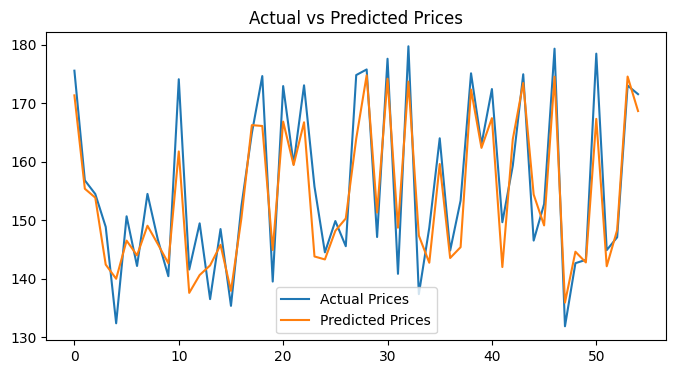

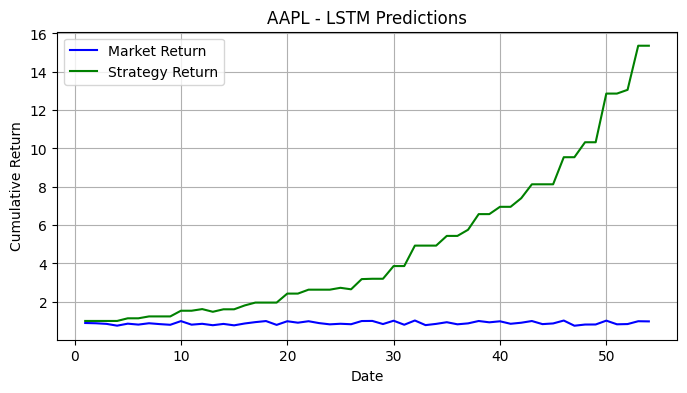

,Cumulative Return,Cumulative Strategy Return
50,1.016578,12.861664
51,0.825329,12.861664
52,0.837863,13.056983
53,0.985530,15.358180
54,0.977155,15.358180


In [33]:
def calc_rsi(stock, window=14):
  delta = stock['Close'].diff(1)
  gain = delta.where(delta > 0, 0)
  loss = -delta.where(delta < 0, 0)

  avg_gain = gain.rolling(window=window).mean()
  avg_loss = loss.rolling(window=window).mean()

  rs = avg_gain / avg_loss
  rsi = 100 - (100 / (1 + rs))

  return rsi

def calc_ema(stock, window=20):
    return stock['Close'].ewm(span=window, adjust=False).mean()

def calc_vwap(stock):
    return (((stock['High'] + stock['Low'] + stock['Close']) / 3) * stock['Volume']).cumsum() / stock['Volume'].cumsum()

def make_model(train_data):
    # step 1: init model
    model = Sequential()

    # step 2: add LSTM layers
    model.add(LSTM(units=32, return_sequences=True, input_shape=(train_data.shape[1], train_data.shape[2])))
    model.add(Dropout(0.2)) # regularization

    model.add(LSTM(units=32, return_sequences=False))
    model.add(Dropout(0.2))

    # step 3: add Dense output layer
    model.add(Dense(units=1)) # Predict the next day's "Close" price

    # step 4: compile model
    model.compile(optimizer='adam',
                  loss='mse')

    # step 5: model summary
    # model.summary()
    return model

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
      X.append(data[i:i + seq_length, :]) # captures all the features in length: seq_length
      y.append(data[i + seq_length, 0]) # captures target: next day's "Close"
    return np.array(X), np.array(y)


def lstm_strategy(ticker, start_date, end_date):
    stock = yf.download(ticker, start=start_date, end=end_date) # yf.download returns OHLCV
    stock.columns = stock.columns.get_level_values(0) # remove multi-level column names

    # step 2: features to feed LSTM model for prediction
    stock['Daily Return'] = stock['Close'].pct_change()
    stock['50MA'] = stock['Close'].rolling(window=50).mean()
    stock['200MA'] = stock['Close'].rolling(window=200).mean()
    stock['Volatility'] = stock['Daily Return'].rolling(window=10).std()
    stock['RSI'] = calc_rsi(stock)
    stock['VWAP'] = calc_vwap(stock)
    stock['20EMA'] = calc_ema(stock)
    stock = stock.dropna()

    # step 3; normalize data
    features = ['Close','Daily Return', '50MA', '200MA', 'Volatility', 'RSI', 'VWAP', '20EMA']
    X = stock[features]
    scaler = MinMaxScaler(feature_range=(0, 1))
    normalized_data = scaler.fit_transform(X)

    # step 4: create sequences


    sequence_length = 30
    X, y = create_sequences(normalized_data, sequence_length)

    # step 5: train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = make_model(X_train)

    # step 6: train model
    history = model.fit(X_train, y_train,
              validation_data=(X_test, y_test),
              epochs=20, batch_size=32, verbose=0) #switch to verbose=1 for DEBUGGING
    print("training done!")

    # step 7: plot training and validation loss (DEBUGGING)
    # plt.plot(history.history['loss'], label='Training Loss')
    # plt.plot(history.history['val_loss'], label='Validation Loss')
    # plt.title('Training and Validation Loss')
    # plt.legend()
    # plt.show()

    # step 8: prediction
    predicted_prices = model.predict(X_test)

    # step 9: de-normalizing our predicted prices and actual prices
      # temp array, same shape as original dataset
    temp = np.zeros((predicted_prices.shape[0], len(features)))
    temp[:,0] = predicted_prices[:,0] # predicted prices go in first column
    predicted_prices_actual = scaler.inverse_transform(temp)[:,0] # take the first column and do inverse normalization to get that actual predicted prices

      # doing the same for y_test
    temp = np.zeros((y_test.shape[0], len(features)))
    temp[:, 0] = y_test[:, 0] if y_test.ndim > 1 else y_test # Place the values of y_test in the first column
    y_test_actual = scaler.inverse_transform(temp)[:, 0] # Perform inverse normalization to get the actual values

    # step 10: checking error and plotting prices? (DEBUGGING)
    # mse = mean_squared_error(y_test_actual, predicted_prices_actual)
    # r2 = r2_score(y_test_actual, predicted_prices_actual)
    # print(f'Mean Squared Error: {mse:.2f}, R-squared: {r2:.2f}')

    plt.figure(figsize=(8,4))
    plt.plot(y_test_actual, label='Actual Prices')
    plt.plot(predicted_prices_actual, label='Predicted Prices')
    plt.title('Actual vs Predicted Prices')
    plt.legend()
    plt.show()

    # step 11: making buy/sell signals
    res = {}
    predicted_trends = np.diff(predicted_prices_actual)
    res['Signal'] = [1 if trend > 0 else 0 for trend in predicted_trends]

    y_test_actual_df = pd.DataFrame(y_test_actual, columns=['Close'])  # Assuming y_test_actual represents 'Close' prices
    y_test_actual_df['Daily Return'] = y_test_actual_df['Close'].pct_change()  # Calculate 'Daily Return'

    y_test_actual_df['Strategy Return'] = y_test_actual_df['Daily Return'][1:] * res['Signal']
    y_test_actual_df['Cumulative Return'] = (1 + y_test_actual_df['Daily Return']).cumprod()
    y_test_actual_df['Cumulative Strategy Return'] = (1 + y_test_actual_df['Strategy Return']).cumprod()

    return y_test_actual_df


tickers = ['AAPL', 'GOOGL', 'MSFT', 'TSLA', 'AMZN']
start_date = '2021-01-01'
end_date = '2023-01-01'
stock_data = lstm_strategy(tickers[0], start_date, end_date)

plt.figure(figsize=(8, 4))
plt.plot(stock_data['Cumulative Return'], label='Market Return', color='blue')
plt.plot(stock_data['Cumulative Strategy Return'], label='Strategy Return', color='green')
plt.title(f'{tickers[0]} - LSTM Predictions')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()


# Display the strategy performance
stock_data[['Cumulative Return', 'Cumulative Strategy Return']].tail()